## Packages

In [156]:
from lasair import LasairError, lasair_client as lasair
from alerce.core import Alerce
import matplotlib.pyplot as plt
import sys, time
import requests
import numpy as np
import pandas as pd
import math

import mysql.connector
import json
from collections import OrderedDict
import matplotlib.image as mpimg
import os
import csv
import io as StringIO

In [157]:
%%html
<style>
table {float:left}
</style>

## Functions

In [158]:
def alerce_retrieval(obj_id):
    print('Importing lightcurves and metadata for source ', obj_id)
    
    # Import Object from Alerce
    lightcurve = alerce.query_lightcurve(obj_id, format="json")
    
    # Separate Detections and Non-detections
    non_detections = pd.DataFrame(lightcurve['non_detections'])
    detections = pd.DataFrame(lightcurve['detections'])
    
    data_cols = ['mjd', 'magpsf']
    metadata_cols = ['fid']
    
    data_unsorted = detections[data_cols]
    metadata = detections[metadata_cols]
    
    idx1 = np.where(np.array([metadata['fid']])[0] == 1)[0]
    idx2 = np.where(np.array([metadata['fid']])[0] == 2)[0]
    
    g_band = data_unsorted.loc[idx1, data_cols]
    r_band = data_unsorted.loc[idx2, data_cols]
    
    data = pd.concat([g_band, r_band], axis=1)
    data.columns = ['mjd_g','magpsf_g','mjd_r','magpsf_r']
    
    return data, metadata

def source_search_lasair(obj_id):
    print('\nSearching for missing objects on Lasair-Iris...')
    lasair_obj = L.objects(alerce_missing)

    lasair_found = []
    lasair_missing = []

    for i in range(len(alerce_missing)):
        if not lasair_obj[i]:
            lasair_missing.append(alerce_missing[i])
        else:
            lasair_found.append(alerce_missing[i])
    
    print('Found', len(lasair_found), 'objects.\n')
    for candidate in lasair_found:
        print(candidate)
        
    print('\n' + str(len(lasair_missing)), 'objects not retrievable.\n')
    for candidate in lasair_missing:
        print(candidate)
        
    return lasair_found, lasair_missing

def source_search_alerce(obj_id):
    print('Number of Objects : ', len(obj_id), '\n')

    i = 0
    objects = pd.DataFrame(columns=['oid', 'ndethist', 'ncovhist', 'mjdstarthist', 'mjdendhist',
           'corrected', 'stellar', 'ndet', 'g_r_max', 'g_r_max_corr', 'g_r_mean',
           'g_r_mean_corr', 'firstmjd', 'lastmjd', 'deltajd', 'meanra', 'meandec',
           'sigmara', 'sigmadec', 'class', 'classifier', 'probability',
           'step_id_corr'])

    print('Querying ALeRCE for', len(obj_id), 'sources...')

    while i < len(obj_id)-10:
        query = alerce.query_objects(oid=obj_id[i:i+10], format="pandas")
        objects = objects.append(query.iloc[0:query.shape[0]])
        i += 10
    
    missing = list([])
    print('Found', objects.shape[0], 'sources. \n')
    print('Missing Objects :')
    for object_ztf in obj_id:
        if object_ztf not in np.array([objects['oid']]):
            missing.append(object_ztf)
            print(object_ztf)
            
    return objects, missing

def plotLC(lc, ztf_name):
    
    jd_now = time.time()/86400 + 40587.0 + 2400000.5
    color = {1:'green', 2:'red'}
    
    for fid in [1,2]:
        
        since = []
        mjd = []
        magpsf = []
        sigmapsf = []
        maglim = []
        
        for cand in lc:
            if cand['fid'] == fid:
                
                try:
                    since.append(cand['jd'] - jd_now)
                    mjd.append(cand['jd'] -  2400000.5)
                    
                    magpsf.append(cand['magpsf'])
                    sigmapsf.append(cand['sigmapsf'])
                    maglim.append(np.nan)
                except KeyError:
                    magpsf.append(np.nan)
                    sigmapsf.append(np.nan)    
                    maglim.append(cand['diffmaglim'])

        plt.errorbar(mjd, magpsf, yerr=sigmapsf, c=color[fid])
        plt.scatter(mjd, maglim, marker="v", c=color[fid])

        plt.xlabel("MJD (d)" )
        plt.ylabel("psf mag")
        
    plt.title('https://lasair-iris.roe.ac.uk/objects/%s' % ztf_name)
    plt.gca().invert_yaxis()
    plt.show()

## Alerce Query

Requires installation of the alerce package. We also use the lasair package for some verifications. Initialisation of the two packages follows below.

In [159]:
alerce = Alerce()

token = !curl --data "username=Oliver&password=1234fisk" https://lasair-iris.roe.ac.uk/api/auth-token/
print(token[-1])

token = '591d4e074bca6a265191593cf4c0e8609e488e1b'
L = lasair(token)

{"token":"591d4e074bca6a265191593cf4c0e8609e488e1b"}


The filter ID in the ALeRCE database is related to the ZTF observation band on Lasair in the following way :

| Filter ID | Observation Band |
| :-: | :-: |
| 1 | G |
| 2 | R |

#### Initial Query
We import the ZTF names of the sources that were identified as blue continuum from the Pessto+ marshall, and run a quick source search routine to determine which ones can be obtained from ALeRCE. 

In [160]:
Blu = pd.read_csv('PesstoOnSpread.csv')
ztf_raw = list(Blu['ZTF'])
ztf_names = [x for x in obj_id_raw if type(x) != float]

alerce_found, alerce_missing = source_search_alerce(ztf_names)
lasair_found, lasair_missing = source_search_lasair(alerce_missing)

Number of Objects :  60 

Querying ALeRCE for 60 sources...
Found 49 sources. 

Missing Objects :
ZTF18aarqliy
ZTF21aapjmgf
ZTF21aaosgqa
ZTF21aaqjmps
ZTF21aabavaz
ZTF21aabjfbc
ZTF20acmmfau
ZTF19abpvbzf
ZTF19aailptb
ZTF19aajwogx
ZTF19abiagjr

Searching for missing objects on Lasair-Iris...
Found 3 objects.

ZTF21aapjmgf
ZTF21aaosgqa
ZTF21aaqjmps

8 objects not retrievable.

ZTF18aarqliy
ZTF21aabavaz
ZTF21aabjfbc
ZTF20acmmfau
ZTF19abpvbzf
ZTF19aailptb
ZTF19aajwogx
ZTF19abiagjr


In [164]:
data, metadata = alerce_retrieval('ZTF19abzwbxy')
print('Data Dimensions : ', data.shape)
print('Features : ', data.columns)
print(data['mjd_g'])

Importing lightcurves and metadata for source  ZTF19abzwbxy
Data Dimensions :  (16, 4)
Features :  Index(['mjd_g', 'magpsf_g', 'mjd_r', 'magpsf_r'], dtype='object')
0     58747.277303
1     58750.208264
2              NaN
3     59335.440567
4              NaN
5     59338.447211
6              NaN
7              NaN
8     59340.441169
9              NaN
10    59342.467546
11    59345.426609
12             NaN
13             NaN
14    59348.443565
15    59354.443738
Name: mjd_g, dtype: float64


KeyError: 'mjd_r'

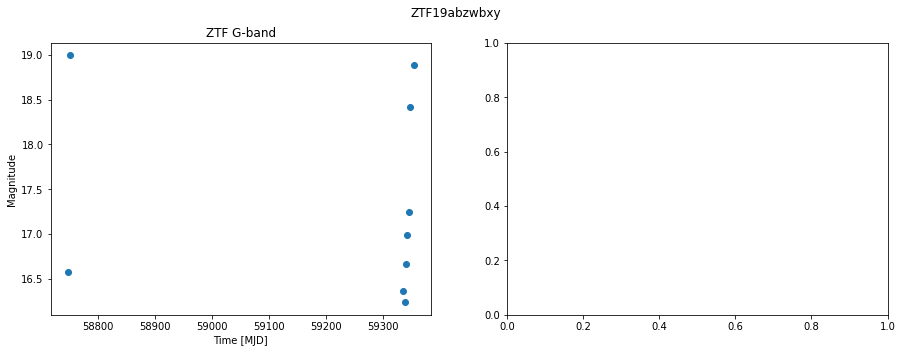

In [163]:
fig, axs = plt.subplots(1, 2)
fig.suptitle('ZTF19abzwbxy')
fig.set_size_inches(15, 5)
axs[0].scatter(data['mjd_g'], data['magpsf_g'])
axs[0].set_title('ZTF G-band')
axs[0].set_xlabel('Time [MJD]')
axs[0].set_ylabel('Magnitude')
axs[1].scatter(lc['mjd_r'], lc['magpsf_r'])
axs[1].set_title('ZTF R-band')
axs[1].set_xlabel('Time [MJD]')
axs[1].set_ylabel('Magnitude')
plt.show()

## Lasair Light Curves
Documentation for the Lasair packages used to query the ZTF database directly can be found at : https://pypi.org/project/lasair/

In [65]:
# Getting detections for an object
detections = alerce.query_detections("ZTF19abzwbxy", format="pandas")

# Getting non detections for an object
non_detections = alerce.query_non_detections("ZTF19abzwbxy", format="pandas")

# Getting lightcurve for an object
lightcurve = alerce.query_lightcurve("ZTF19abzwbxy", format="pandas")

In [70]:
print(detections.columns)

Index(['mjd', 'candid', 'fid', 'pid', 'diffmaglim', 'isdiffpos', 'nid',
       'distnr', 'magpsf', 'magpsf_corr', 'magpsf_corr_ext', 'magap',
       'magap_corr', 'sigmapsf', 'sigmapsf_corr', 'sigmapsf_corr_ext',
       'sigmagap', 'sigmagap_corr', 'ra', 'dec', 'rb', 'rbversion', 'drb',
       'magapbig', 'sigmagapbig', 'rfid', 'has_stamp', 'corrected', 'dubious',
       'candid_alert', 'step_id_corr', 'phase', 'parent_candid'],
      dtype='object')


In [71]:
print(lightcurve.columns)

Index(['detections', 'non_detections'], dtype='object')


In [68]:
pd.DataFrame(lightcurve['detections'])

,detections
0,"[{'mjd': 58747.277303200215, 'candid': '993277..."


In [72]:
print(lc.columns)

Index(['mjd', 'candid', 'fid', 'pid', 'diffmaglim', 'isdiffpos', 'nid',
       'distnr', 'magpsf', 'magpsf_corr', 'magpsf_corr_ext', 'magap',
       'magap_corr', 'sigmapsf', 'sigmapsf_corr', 'sigmapsf_corr_ext',
       'sigmagap', 'sigmagap_corr', 'ra', 'dec', 'rb', 'rbversion', 'drb',
       'magapbig', 'sigmagapbig', 'rfid', 'has_stamp', 'corrected', 'dubious',
       'candid_alert', 'step_id_corr', 'phase', 'parent_candid'],
      dtype='object')


#### Load object ID for the blue continuum candidates

In [49]:
Blu = pd.read_csv('PesstoOnSpread.csv')
obj_id_raw = list(Blu['ZTF'])
obj_id = [x for x in obj_id_raw if type(x) != float]

Number of Objects :  60 

ZTF19abzwbxy
ZTF19aadhafu
ZTF18aarqliy
ZTF18abklbam
ZTF18ablwafp
ZTF18abqbuaj
ZTF18abqcsdq
TF18acrwkxw
ZTF18abthaii
ZTF18abtswjk
ZTF18abvzdvj
ZTF18abwkrbl
ZTF18acrwheu
ZTF18acszayr
ZTF20aczdnmp
ZTF19aalubxw
ZTF19aanjvsb
ZTF19aapreis
ZTF19aatrbqs
ZTF19aauspho
ZTF19abeyvoi
ZTF19abgmkef
ZTF19abguqsi
ZTF19abhcefa
ZTF19abidbya
ZTF19abnobkg
ZTF19abrtjsf
ZTF18abmxaxt
ZTF19abuilka
ZTF19acgfvvi
ZTF19ackbclh
ZTF19acjwdnu
ZTF20acjfkbb
ZTF20acqlcge
ZTF20aclkdlu
ZTF19aaabvzh
ZTF20acocohy
ZTF20acohkja
ZTF20acpvbbh
ZTF21aaeoqxf
ZTF21aaedpyk
ZTF21aaevrjl
ZTF21aaglrzc
ZTF21aagpymw
ZTF21aagogqj
ZTF21aaiaeri
ZTF21aaipypa
ZTF21aajvukh
ZTF21aalhgqi
ZTF21aaphlty
ZTF21aapjmgf
ZTF21aaosgqa
ZTF21aaqjmps
ZTF21aabavaz
ZTF21aabjfbc
ZTF20acmmfau
ZTF19abpvbzf
ZTF19aailptb
ZTF19aajwogx
ZTF19abiagjr


#### Retrieve light curves for the corresponding IDs

In [45]:
test = L.objects([obj_id[0]])
print(test[0])

{'objectId': 'ZTF19abzwbxy', 'objectData': {'ncand': 10, 'ramean': 305.86045146999993, 'decmean': 6.666885639999999, 'glonmean': 49.97618229835333, 'glatmean': -17.005897795669487, 'jdmin': 2459335.9405671, 'jdmax': 2459345.9736111, 'rasex': '20:23:26.508', 'decsex': '06:40:0.788', 'ec_lon': 310.0432797083914, 'ec_lat': 25.259182797193276, 'now_mjd': '59494.56', 'mjdmin_ago': 159.11494170968945, 'mjdmax_ago': 149.08189770953322}, 'candidates': [{'candid': 1600443736215015022, 'jd': 2459354.9437384, 'ra': 305.8604597, 'dec': 6.6669723, 'fid': 1, 'nid': 1600, 'magpsf': 18.88062858581543, 'sigmapsf': 0.15144285559654236, 'isdiffpos': 't', 'ssdistnr': -999.0, 'ssnamenr': 'null', 'drb': None, 'mjd': 59354.443738400005, 'since_now': -140.11177040963958, 'utc': '2021-05-20 10:38:58'}, {'jd': 2459352.9635995, 'fid': 1, 'diffmaglim': 20.484100341796875, 'mjd': 59352.46359949978, 'since_now': -142.0919093098637, 'magpsf': 20.484100341796875}, {'jd': 2459352.9262616, 'fid': 2, 'diffmaglim': 20.30

#### Plot the light curves

ZTF19abzwbxy


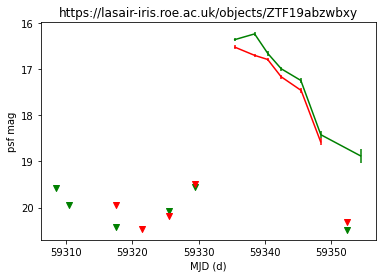

ZTF18abfkres


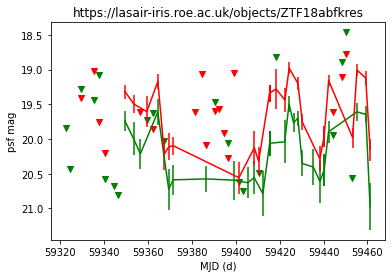

ZTF19aaabvzh


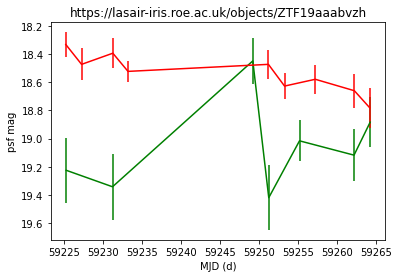

ZTF20acpvbbh


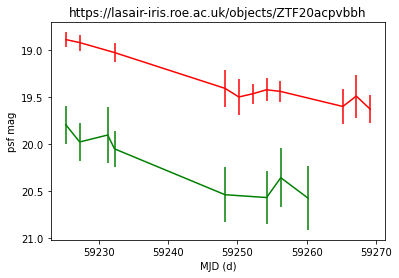

ZTF21aaeoqxf


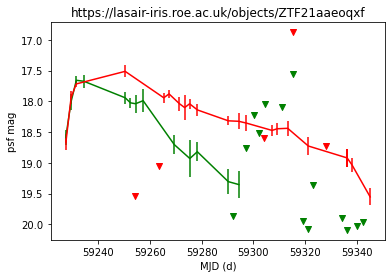

ZTF21aaedpyk


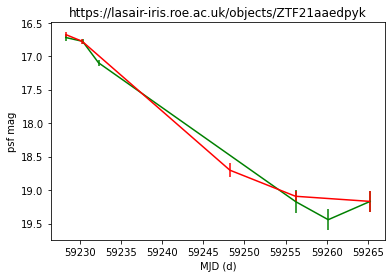

ZTF21aaevrjl


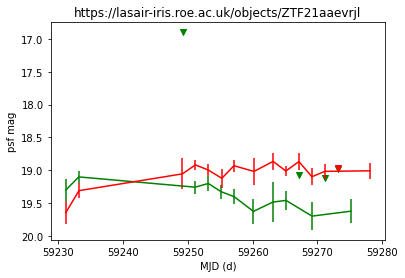

ZTF21aaglrzc


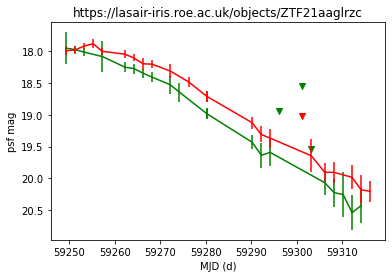

ZTF21aaiaeri


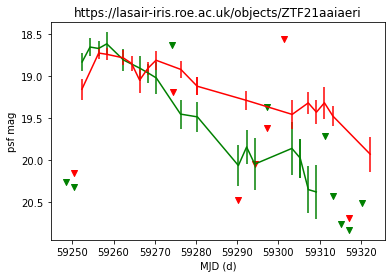

ZTF21aaipypa


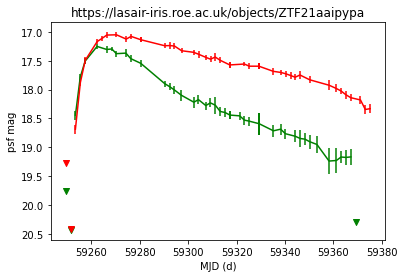

ZTF21aajvukh


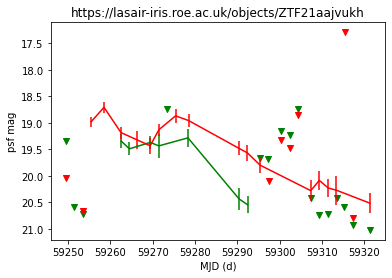

ZTF21aalhgqi


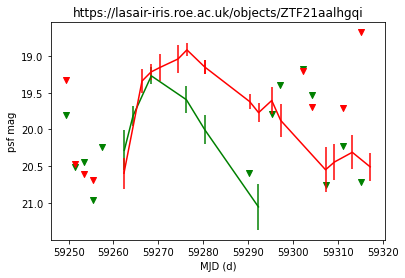

ZTF21aaarmti


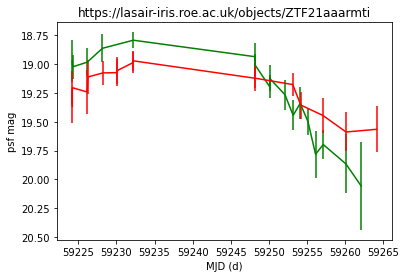

ZTF21aaqjmps


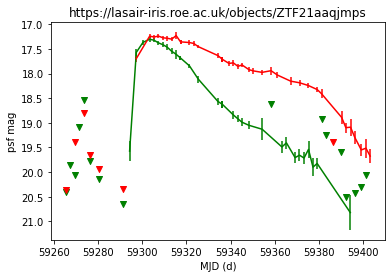

ZTF19aaaciwt


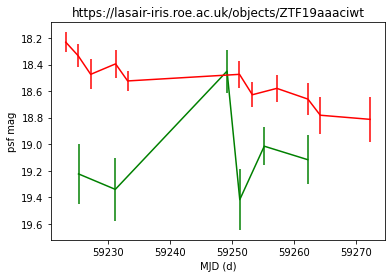

ZTF19aailptb


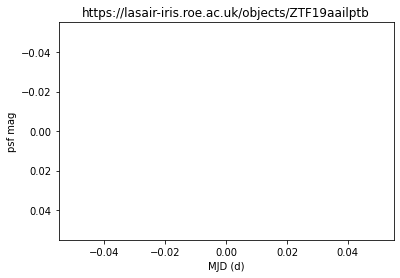

ZTF19aajwogx


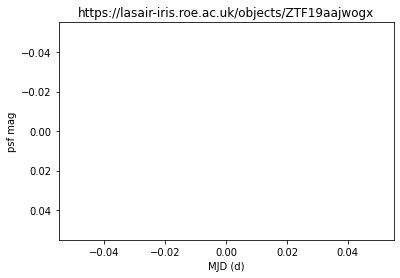

ZTF19abiagjr


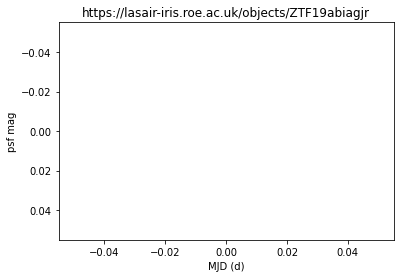

In [50]:
#obj_id = ['ZTF19abzwbxy', 'ZTF18abfkres', 'ZTF19aaabvzh', 'ZTF20acpvbbh', 'ZTF21aaeoqxf', 'ZTF21aaedpyk', 'ZTF21aaevrjl', 'ZTF21aaglrzc', 'ZTF21aaiaeri', 'ZTF21aaipypa', 'ZTF21aajvukh', 'ZTF21aalhgqi', 'ZTF21aaarmti', 'ZTF21aaqjmps', 'ZTF19aaaciwt', 'ZTF19aailptb', 'ZTF19aajwogx', 'ZTF19abiagjr']

lcs = L.lightcurves(obj_id)

for i in range(len(obj_id)):
    print(obj_id[i])
    plotLC(lcs[i], obj_id[i])

## TNS Query
The API key was obtained for the ENID bot, and is : **0edfe1b95fd8f8e22102d531bb786d65fe1ce219**

In [2]:
def set_bot_tns_marker():
    tns_marker = 'tns_marker{"tns_id": "' + str(TNS_BOT_ID) + '", "type": "bot", "name": "' + TNS_BOT_NAME + '"}'
    return tns_marker

def format_to_json(source):
    parsed = json.loads(source, object_pairs_hook = OrderedDict)
    result = json.dumps(parsed, indent = 4)
    return result

def is_string_json(string):
    try:
        json_object = json.loads(string)
    except Exception:
        return False
    return json_object

def print_status_code(response):
    json_string = is_string_json(response.text)
    if json_string != False:
        print ("status code ---> [ " + str(json_string['id_code']) + " - '" + json_string['id_message'] + "' ]\n")
    else:
        status_code = response.status_code
        if status_code == 200:
            status_msg = 'OK'
        elif status_code in ext_http_errors:
            status_msg = err_msg[ext_http_errors.index(status_code)]
        else:
            status_msg = 'Undocumented error'
        print ("status code ---> [ " + str(status_code) + " - '" + status_msg + "' ]\n")

def search():
    search_url = url_tns_api + "/search"
    tns_marker = set_bot_tns_marker()
    headers = {'User-Agent': tns_marker}
    json_file = OrderedDict(search_obj)
    search_data = {'api_key': TNS_API_KEY, 'data': json.dumps(json_file)}
    response = requests.post(search_url, headers = headers, data = search_data)
    return response

def get():
    get_url = url_tns_api + "/object"
    tns_marker = set_bot_tns_marker()
    headers = {'User-Agent': tns_marker}
    json_file = OrderedDict(get_obj)
    get_data = {'api_key': TNS_API_KEY, 'data': json.dumps(json_file)}
    response = requests.post(get_url, headers = headers, data = get_data)
    return response

def get_file():
    filename = os.path.basename(file_tns_url)
    tns_marker = set_bot_tns_marker()
    headers = {'User-Agent': tns_marker}
    api_data = {'api_key': TNS_API_KEY}
    print ("Downloading file '" + filename + "' from the TNS...\n")
    response = requests.post(file_tns_url, headers = headers, data = api_data, stream = True)    
    print_status_code(response)
    path = os.path.join(download_dir, filename)
    if response.status_code == 200:
        with open(path, 'wb') as f:
            for chunk in response:
                f.write(chunk)
        print ("File was successfully downloaded.\n")
    else:
        print ("File was not downloaded.\n")

def print_response(response, json_file, counter):
    response_code = str(response.status_code) if json_file == False else str(json_file['id_code'])
    stats = 'Test #' + str(counter) + '| return code: ' + response_code + \
            ' | Total Rate-Limit: ' + str(response.headers.get('x-rate-limit-limit')) + \
            ' | Remaining: ' + str(response.headers.get('x-rate-limit-remaining')) + \
            ' | Reset: ' + str(response.headers.get('x-rate-limit-reset'))
    if(response.headers.get('x-cone-rate-limit-limit') != None):
        stats += ' || Cone Rate-Limit: ' + str(response.headers.get('x-cone-rate-limit-limit')) + \
                 ' | Cone Remaining: ' + str(response.headers.get('x-cone-rate-limit-remaining')) + \
                 ' | Cone Reset: ' + str(response.headers.get('x-cone-rate-limit-reset'))
    print (stats)

def get_reset_time(response):
    # If any of the '...-remaining' values is zero, return the reset time
    for name in response.headers:
        value = response.headers.get(name)
        if name.endswith('-remaining') and value == '0':
            return int(response.headers.get(name.replace('remaining', 'reset')))
    return None

def rate_limit_handling():
    counter = 0
    while True:
        counter = counter + 1
        response = search()
        json_file = is_string_json(response.text)
        print_response(response, json_file, counter)
        # Checking if rate-limit reached (...-remaining = 0)
        reset = get_reset_time(response)
        # A general verification if not some error 
        if (response.status_code == 200):
            if reset != None:
                # Sleeping for reset + 1 sec
                print("Sleep for " + str(reset + 1) + " sec") 
                time.sleep(reset + 1)
        	    # Can continue to submit requests...
                print ("Continue to submit requests...")
                for i in range(3):
                    counter = counter + 1
                    response = search()
                    json_file = is_string_json(response.text)
                    print_response(response, json_file, counter)
                print ("etc...\n") 
                break
        else:
            print_status_code(response)       
            break

In [3]:
TNS                 = "sandbox.wis-tns.org"
url_tns_api         = "https://" + TNS + "/api/get"

TNS_BOT_ID          = "117327"
TNS_BOT_NAME        = "ENID"
TNS_API_KEY         = "0edfe1b95fd8f8e22102d531bb786d65fe1ce219"

# current working directory
cwd                 = os.getcwd()
# directory for downloaded files
download_dir        = os.path.join(cwd, "downloaded_files")

# external http errors
ext_http_errors     = [403, 500, 503]
err_msg             = ["Forbidden", "Internal Server Error: Something is broken", "Service Unavailable"]

In [53]:
search_obj          = [("ra", "15:57:28"), ("dec", "+30:03:39"), ("radius", "5"), ("units", "arcsec"), 
                       ("objname", ""), ("objname_exact_match", 0), ("internal_name", ""), 
                       ("internal_name_exact_match", 0), ("objid", ""), ("public_timestamp", "")]

In [54]:
search_url = url_tns_api + "/search"

In [55]:
tns_marker = set_bot_tns_marker()
print(tns_marker)

In [57]:
headers = {'User-Agent': tns_marker}

In [58]:
json_file = OrderedDict(search_obj)

In [59]:
search_data = {'api_key': TNS_API_KEY, 'data': json.dumps(json_file)}

In [60]:
print(search_data)

{'api_key': '0edfe1b95fd8f8e22102d531bb786d65fe1ce219', 'data': '{"ra": "15:57:28", "dec": "+30:03:39", "radius": "5", "units": "arcsec", "objname": "", "objname_exact_match": 0, "internal_name": "", "internal_name_exact_match": 0, "objid": "", "public_timestamp": ""}'}


In [61]:
response = requests.post(search_url, headers = headers, data = search_data)

In [65]:
print(response)

<Response [200]>


In [63]:
#url_tns_api = 'https://wis-tns.weizmann.ac.il/api/get/'

# EXAMPLE 1 (search obj)
search_obj          = [("ra", "15:57:28"), ("dec", "+30:03:39"), ("radius", "5"), ("units", "arcsec"), 
                       ("objname", ""), ("objname_exact_match", 0), ("internal_name", ""), 
                       ("internal_name_exact_match", 0), ("objid", ""), ("public_timestamp", "")]
response = search()
json_data = format_to_json(response.text)
print (json_data)

{
    "id_code": 200,
    "id_message": "OK",
    "data": {
        "received_data": {
            "ra": "15:57:28",
            "dec": "+30:03:39",
            "radius": 5,
            "units": "arcsec",
            "objname": "",
            "objname_exact_match": 0,
            "internal_name": "",
            "internal_name_exact_match": 0,
            "objid": "",
            "public_timestamp": ""
        },
        "reply": [
            {
                "objname": "2017A",
                "prefix": "SN",
                "objid": 17010
            }
        ]
    }
}


In [66]:
# EXAMPLE 2 (get obj)
get_obj             = [("objname", "2017A"), ("objid", ""), ("photometry", "1"), ("spectra", "0")]
response = get()
json_data = format_to_json(response.text)
print (json_data)

# EXAMPLE 3 (get file from TNS)
file_tns_url        = "https://" + TNS + "/system/files/uploaded/"\
                      "Padova-Asiago/tns_2017A_2457777.69_Ekar_AFOSC_Padova-Asiago.txt"
get_file()

# EXAMPLE 4 (test rate-limit search)
search_obj          = [("ra", ""), ("dec", ""), ("radius", ""), ("units", ""), 
                       ("objname", "2021rak"), ("objname_exact_match", 0), ("internal_name", ""), 
                       ("internal_name_exact_match", 0), ("objid", ""), ("public_timestamp", "")]
rate_limit_handling()

# EXAMPLE 5 (test rate-limit cone search)
search_obj          = [("ra", "15:57:28"), ("dec", "+30:03:39"), ("radius", "5"), ("units", "arcsec"), 
                       ("objname", ""), ("objname_exact_match", 0), ("internal_name", ""), 
                       ("internal_name_exact_match", 0), ("objid", ""), ("public_timestamp", "")]
rate_limit_handling()

{
    "id_code": 200,
    "id_message": "OK",
    "data": {
        "received_data": {
            "objname": "2017A",
            "objid": "",
            "photometry": 1,
            "spectra": 0
        },
        "reply": {
            "objname": "2017A",
            "name_prefix": "SN",
            "objid": 17010,
            "object_type": {
                "name": "SN Ia",
                "id": 3
            },
            "redshift": 0.0328,
            "ra": "15:57:28.350",
            "dec": "+30:03:39.10",
            "radeg": 239.368125,
            "decdeg": 30.060861,
            "radeg_err": 0.00055555555555556,
            "decdeg_err": 0.00055555555555556,
            "hostname": "UGC10104",
            "host_redshift": null,
            "internal_names": "",
            "discoverer_internal_name": "",
            "discoverydate": "2017-01-01 05:26:01.000",
            "discoverer": "Grzegorz Duszanowicz, Michal Zolnowski",
            "reporter": "Grzegorz Duszanowicz

FileNotFoundError: [Errno 2] No such file or directory: '/Users/oliverdurfeldtpedros/Documents/PythonEnv/Synthesis/Code/downloaded_files/tns_2017A_2457777.69_Ekar_AFOSC_Padova-Asiago.txt'